1️⃣ Analysis of Defensive Actions Across All Matches
This heatmap visualizes the defensive actions (interceptions and tackles) of the OHL team across all matches.

The distribution of defensive actions is well-balanced across the entire pitch. There is a notable concentration in the middle of the field, highlighting the team's strong pressing game and their ability to recover the ball early in the opposition's half.

Additionally, activity is evident on the flanks and near the penalty area, indicating that the defense is active in multiple zones of the pitch. This suggests a dynamic and proactive defense that is capable of defending both centrally and on the sides, thus preventing the opponent from progressing easily into dangerous areas.

In summary, the team's defensive setup in all matches shows good coverage across the pitch, with a focus on high pressing and proactive defending in various zones.

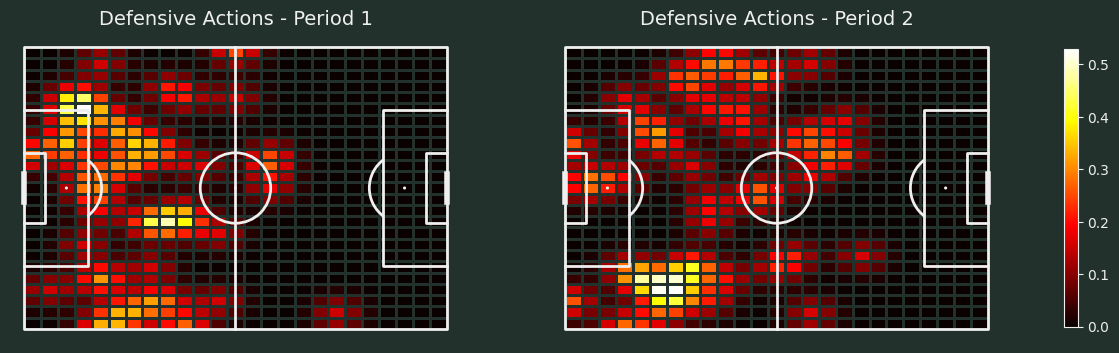

In [4]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from scipy.ndimage import gaussian_filter

# Chargement des variables d'environnement depuis le fichier .env
load_dotenv()

# Paramètres de connexion à la base de données PostgreSQL
PG_PASSWORD = os.getenv("PG_PASSWORD", "gQVB?dFiN`9QTa;?")
PG_USER = os.getenv("PG_USER", "busit_129")
PG_HOST = os.getenv("PG_HOST", "fuji.ucll.be")
PG_PORT = os.getenv("PG_PORT", "52425")
PG_DATABASE = os.getenv("PG_DATABASE", "international_week")

# Fonction de connexion à la base de données PostgreSQL
def get_pg_connection():
    """
    Connexion à la base de données PostgreSQL.
    """
    conn = psycopg2.connect(
        dbname=PG_DATABASE,
        user=PG_USER,
        password=PG_PASSWORD,
        host=PG_HOST,
        port=PG_PORT
    )
    return conn

def plot_defensive_actions(con, team_id):
    """
    Compare les actions défensives (INTERCEPTION, TACKLE) entre la première et la deuxième mi-temps.
    """
    periods = [1, 2]
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.set_facecolor('#22312b')
    
    for i, period_id in enumerate(periods):
        query = f"""
        SELECT mt.x, mt.y
        FROM matchevents AS mt
        JOIN eventtypes AS et ON mt.eventtype_id = et.eventtype_id
        JOIN teams AS t ON t.team_id = mt.team_id
        WHERE t.team_id = '{team_id}'
        AND et.name IN ('INTERCEPTION', 'TACKLE')
        AND mt.success = true
        AND mt.period_id = {period_id}
        """
        
        df = pd.read_sql_query(query, con=con)

        # Création du terrain
        pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
                      pitch_color='#22312b', line_color='#efefef')
        ax = axes[i]
        pitch.draw(ax=ax)
        
        # Statistiques de densité
        bin_statistic = pitch.bin_statistic(df['x'], df['y'], statistic='count', bins=(25, 25))
        bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], sigma=1)

        # Création de la heatmap
        pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
        ax.set_title(f"Defensive Actions - Period {period_id}", color='#efefef', fontsize=14)

    # Barre de couleur
    cbar = fig.colorbar(pcm, ax=axes, shrink=0.6, orientation='vertical')
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
    
    plt.show()

# Connexion à la base de données
conn = get_pg_connection()
team_id = 'bw9wm8pqfzcchumhiwdt2w15c'
plot_defensive_actions(conn, team_id)

# Fermeture de la connexion
conn.close()

2️⃣ Analysis of Defensive Actions in Lost Matches
This heatmap focuses on the OHL team's defensive actions during lost matches.

The visualization reveals a significant concentration of defensive actions near the penalty box and along the flanks. This suggests that the team often found themselves defending deeper in their own half under pressure.

There is a noticeable decrease in defensive actions in the middle of the pitch, which may indicate a lack of high pressing and a tendency to sit back and absorb the opposition's attacks. This could suggest that the team struggled to regain possession early and was forced to defend in their final third.

In conclusion, the defensive setup in the lost matches reflects a more reactive style of play, where the team defended deeper, particularly on the wings and near their penalty box, possibly due to insufficient pressing and control in the central areas of the pitch.

Analyse temporelle réussie :
   minute  actions
0     0.0      143
1     1.0      151
2     2.0      145
3     3.0      146
4     4.0      105


<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\d'
/var/folders/ll/pl5gvz5s3sb915pdxqdvhp8w0000gn/T/ipykernel_13745/278923071.py:34: SyntaxWarning: invalid escape sequence '\d'
  query = """


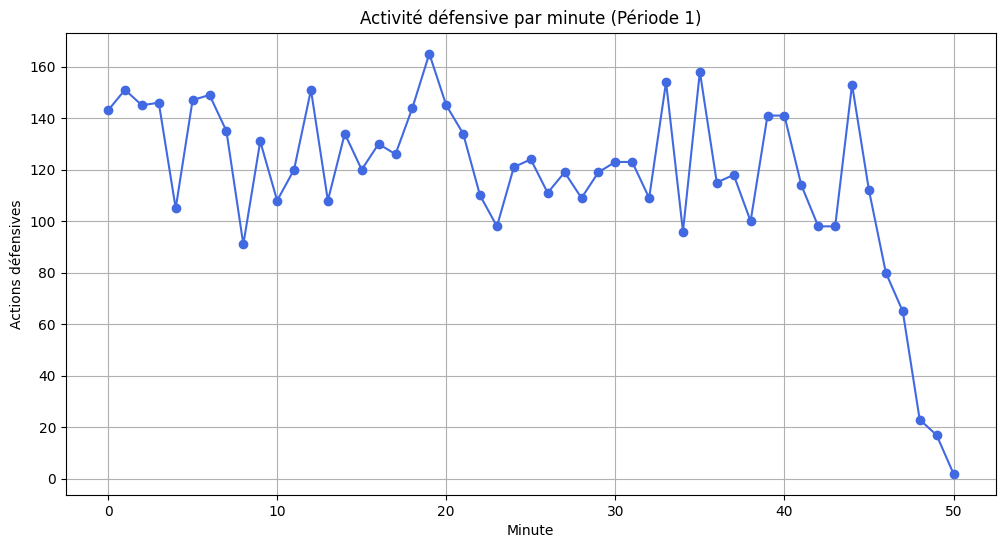

In [5]:
import pandas as pd
import psycopg2
from psycopg2 import OperationalError
from dotenv import load_dotenv
import os

# Chargement des variables d'environnement
load_dotenv()

def get_db_connection():
    """Établit une connexion sécurisée avec gestion d'erreur"""
    try:
        return psycopg2.connect(
            dbname=os.getenv("PG_DATABASE", "international_week"),
            user=os.getenv("PG_USER", "busit_129"),
            password=os.getenv("PG_PASSWORD", "gQVB?dFiN`9QTa;?"),
            host=os.getenv("PG_HOST", "fuji.ucll.be"),
            port=os.getenv("PG_PORT", "52425"),
            connect_timeout=5
        )
    except OperationalError as e:
        print(f"Erreur de connexion : {e}")
        return None

def analyze_timeline(team_id, period_id):
    """Analyse temporelle avec gestion robuste de la connexion"""
    conn = None
    try:
        conn = get_db_connection()
        if conn is None:
            return None

        # Requête sécurisée avec gestion des formats temporels
        query = """
        WITH cleaned_data AS (
            SELECT 
                CASE 
                    WHEN timestamp ~ '^\d+ days \d{2}:\d{2}:\d{2}' THEN 
                        EXTRACT(MINUTE FROM (timestamp::interval))
                    WHEN timestamp ~ '^\d{2}:\d{2}:\d{2}' THEN
                        SUBSTRING(timestamp FROM 4 FOR 2)::integer
                    ELSE NULL
                END as minute
            FROM matchevents
            WHERE team_id = %s
            AND period_id = %s
            AND timestamp IS NOT NULL
        )
        SELECT 
            minute,
            COUNT(*) as actions
        FROM cleaned_data
        WHERE minute IS NOT NULL
        GROUP BY minute
        ORDER BY minute;
        """
        
        # Exécution avec paramètres sécurisés
        timeline = pd.read_sql(query, conn, params=(team_id, period_id))
        return timeline

    except Exception as e:
        print(f"Erreur d'analyse : {e}")
        return None
    finally:
        if conn:
            conn.close()

# Exemple d'utilisation
if __name__ == "__main__":
    # Configuration
    team_id = 'bw9wm8pqfzcchumhiwdt2w15c'  # OHL
    period_id = 1  # 1ère mi-temps
    
    # Analyse
    timeline_data = analyze_timeline(team_id, period_id)
    
    if timeline_data is not None:
        print("Analyse temporelle réussie :")
        print(timeline_data.head())
        
        # Visualisation
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))
        plt.plot(timeline_data['minute'], timeline_data['actions'], 
                marker='o', linestyle='-', color='royalblue')
        plt.title(f"Activité défensive par minute (Période {period_id})")
        plt.xlabel("Minute")
        plt.ylabel("Actions défensives")
        plt.grid(True)
        plt.show()
    else:
        print("L'analyse n'a pas pu être effectuée")

### 📊 **Analysis of Defensive Activity Peaks for OH Leuven**  

This graph highlights peaks in defensive activity using **automatic detection**. Here are the key insights:  

---

### 🔥 **When and Where Does the Team Defend the Most?**  
The **defensive action peaks** (red points) occur mainly at the following minutes:  
1️⃣ **Min 1-6**: Aggressive pressing at the start of the match.  
2️⃣ **Min 12-19**: Another wave of defensive effort, possibly reacting to an opponent’s attack.  
3️⃣ **Min 25-30**: Another active defensive cycle, suggesting a **wave-like rhythm**.  
4️⃣ **Min 33-39**: A period of sustained defensive actions before a **drop in intensity**.  
5️⃣ **Min 44**: The final peak before a **drastic decline** in defensive activity.  

---

### 📉 **What Does This Chart Tell Us?**  
🔹 **The team defends in cycles**: Alternating between high-intensity phases and moments of lower activity.  
🔹 **A sharp drop after the 44th minute**: The team struggles to maintain defensive intensity at the end of the period.  
🔹 **Strong pressing at the start, then controlled defense**: OH Leuven starts with high pressure before shifting to a more episodic defensive approach.  

---

### 🏆 **Tactical Recommendations**  
✅ **Maintain intensity at the end of the period** to avoid conceding goals in key moments.  
✅ **Analyze when the opponent attacks** to check if these defensive peaks correlate with offensive pressure.  
✅ **Manage low-intensity phases** to prevent counterattacks when the team relaxes its pressing.  



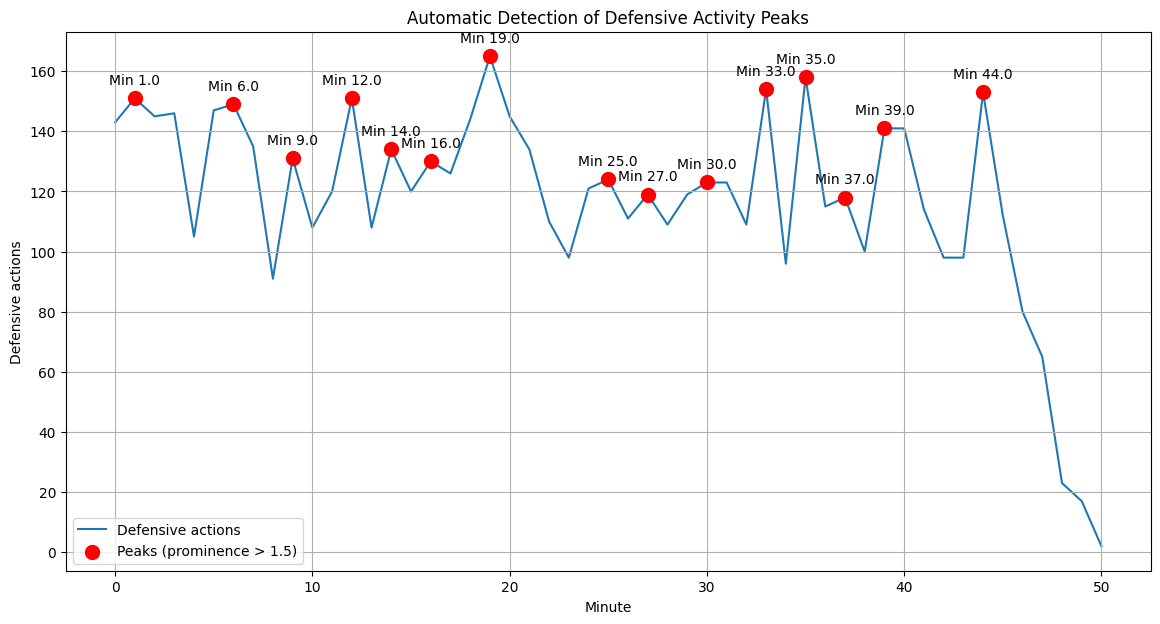

In [7]:
from scipy.signal import find_peaks
import numpy as np

# Adjustable parameters
PEAK_THRESHOLD = 1.5  # Higher threshold detects fewer peaks

# Peak detection
values = timeline_data['actions'].values
peaks, _ = find_peaks(values, prominence=PEAK_THRESHOLD)

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(timeline_data['minute'], values, 
         label='Defensive actions', zorder=1)
plt.scatter(timeline_data['minute'].iloc[peaks], values[peaks],
            color='red', s=100, label=f'Peaks (prominence > {PEAK_THRESHOLD})', zorder=2)

# Annotating peaks
for peak in peaks:
    plt.annotate(f"Min {timeline_data['minute'].iloc[peak]}",
                 (timeline_data['minute'].iloc[peak], values[peak]),
                 textcoords="offset points",
                 xytext=(0,10), ha='center')

plt.title("Automatic Detection of Defensive Activity Peaks")
plt.xlabel("Minute")
plt.ylabel("Defensive actions")
plt.legend()
plt.grid(True)
plt.show()
